In [1]:
import json
import os
import glob

import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import numpy as np
import cv2 as cv
from operator import itemgetter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
SCITSR_PATH = '/Users/longhoang/Developer/table-recognition/data/SciTSR'
# NOTE: change the path to your dataset above 👆

SCITSR_TRAIN = os.path.join(SCITSR_PATH, 'train')
SCITSR_TEST = os.path.join(SCITSR_PATH, 'test')

In [3]:
def get_files(folders, ext):
    total_files = []
    for folder in folders:
        files = glob.glob(folder + '/*.' + ext)
        files.sort()
        total_files.extend(files)
    return total_files

In [4]:
SCITSR_TRAIN_IMG = os.path.join(SCITSR_TRAIN, 'img')
imgs_paths = get_files([SCITSR_TRAIN_IMG], 'png')
len(imgs_paths)

12000

In [5]:
def load_img(img_path):
    img = cv.imread(img_path)
    if img is None:
        print(f"* Error: Unable to read image from {img_path}")
        return None
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def view_imgs(imgs):
    fig = plt.figure(figsize=(7,7))
    for i, img in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        if img.ndim == 3:
            if img.shape[-1] == 3:
                plt.imshow(img)
            else:
                plt.imshow(img[..., 0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.show()

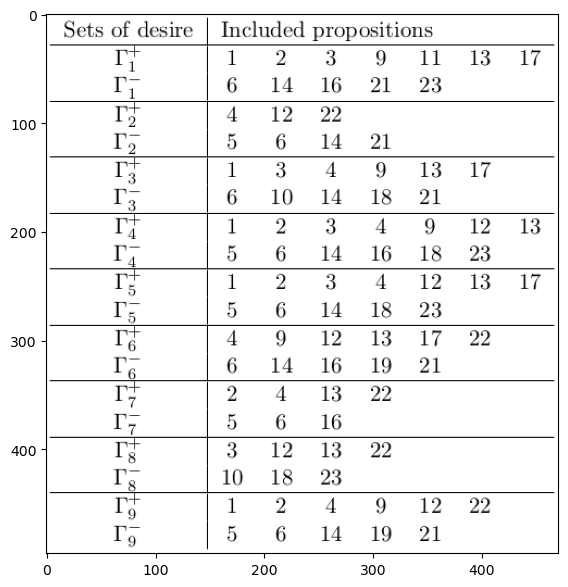

Shape: (496, 471, 3)


In [20]:
# img_path = imgs_paths[15]
img_path = os.path.join(SCITSR_TRAIN_IMG, '1211.6244v4.7' + '.png')
img = load_img(img_path)
view_imgs([img])
print(f'Shape: {img.shape}')

In [21]:
def get_table_pos(pdf_path, display=False):
    imgs_pdf = convert_from_path(pdf_path, 150)
    assert len(imgs_pdf) == 1, 'There is more than one pdf image'
    img_pdf = np.array(imgs_pdf[0])
    gray = cv.cvtColor(img_pdf, cv.COLOR_RGB2GRAY)
    thresh, gray = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    coords = cv.findNonZero(gray)
    x, y, w, h = cv.boundingRect(coords)
    left, top, right, bottom = x - 3, y - 3, x + w + 3, y + h + 3
    if display:
        top_left = (round(left), round(top))
        bottom_right = (round(right), round(bottom))
        cv.rectangle(img_pdf, top_left, bottom_right, (0, 0, 255), 3)
        view_imgs([img_pdf])
        print('Shape: ' + str(img_pdf.shape))
    return left, top, right, bottom

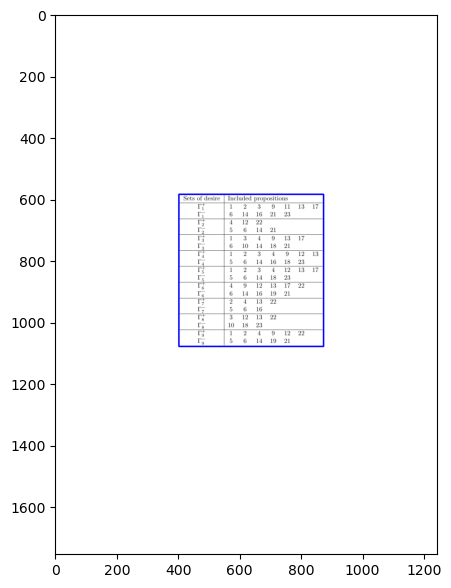

Shape: (1754, 1241, 3)
Top left: (583, 402)
Bottom right: (1078, 872)


In [22]:
img_pdf_path = img_path.replace('png', 'pdf').replace('img', 'pdf')

left, top, right, bottom = get_table_pos(img_pdf_path, True)
print(f'Top left: ({top}, {left})')
print(f'Bottom right: ({bottom}, {right})')

In [23]:
def coord_pdf2img(x, y, left, top):
    ratio = 1754 / 842
    new_x = x * ratio - left
    new_y = 1754 - y * ratio - top
    return new_x, new_y

def read_chunk(chunk_path, left, top, display=False):
    Chunks = []
    with open(chunk_path) as f:
      data = json.load(f)
      chunks = data['chunks']
      #print(len(chunks))
      for c in chunks:
          pos = c['pos']
          l,r,t,b = int(pos[0]), int(pos[1]), int(pos[2]), int(pos[3])
          if display: print('OG       :', l,t,r,b, '--', c['text'])
          l,t = coord_pdf2img(l,t, left, top)
          r,b = coord_pdf2img(r,b, left, top)
          if display: print('Converted:', int(l), int(t), int(r), int(b))
          if t > b: t, b = b, t
          Chunks.append((c['text'], [int(l), int(t), int(r), int(b)]))
        #   Chunks.append((c['text'], [int(l), int(t)-5, int(r), int(b)]))
    return Chunks

In [24]:
img_chunk_path = img_path.replace('png', 'chunk').replace('img', 'chunk')

chunks = read_chunk(img_chunk_path, left, top, True)

OG       : 200 552 257 556 -- Sets of desire
Converted: 14 21 133 12
OG       : 269 552 363 556 -- Included propositions
Converted: 158 21 354 12
OG       : 222 536 234 547 -- Γ +  
1
Converted: 60 54 85 31
OG       : 272 539 277 544 -- 1
Converted: 164 48 175 37
OG       : 293 539 298 544 -- 2
Converted: 208 48 218 37
OG       : 315 539 320 544 -- 3
Converted: 254 48 264 37
OG       : 337 539 342 544 -- 9
Converted: 300 48 310 37
OG       : 357 539 367 544 -- 11
Converted: 341 48 362 37
OG       : 379 539 389 544 -- 13
Converted: 387 48 408 37
OG       : 401 539 411 544 -- 17
Converted: 433 48 454 37
OG       : 222 524 234 536 -- Γ −  
1
Converted: 60 79 85 54
OG       : 272 527 277 532 -- 6
Converted: 164 73 175 62
OG       : 291 527 301 532 -- 14
Converted: 204 73 225 62
OG       : 313 527 323 532 -- 16
Converted: 250 73 270 62
OG       : 335 527 345 532 -- 21
Converted: 295 73 316 62
OG       : 357 527 367 532 -- 23
Converted: 341 73 362 62
OG       : 222 512 234 522 -- Γ +  
2
Con

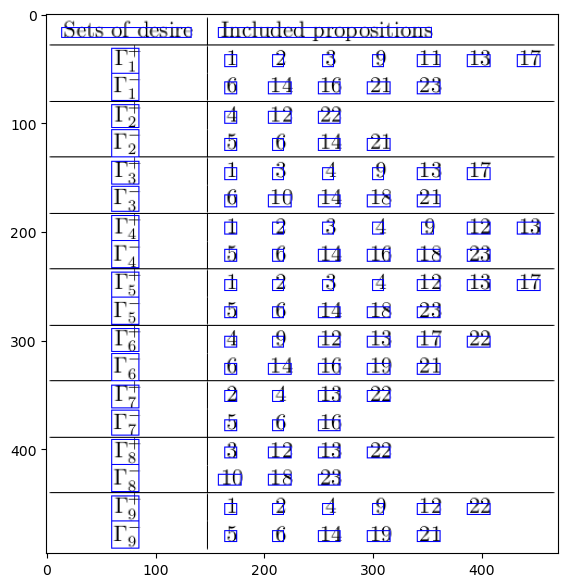

In [25]:
img_draw = img.copy()

for chunk in chunks:
    pos = chunk[1]
    left_top = (pos[0], pos[1])
    bottom_right = (pos[2], pos[3])
    cv.rectangle(img_draw, left_top, bottom_right, (0, 0, 255), 1)

view_imgs([img_draw])

In [26]:
def read_cells(struct_path):
    Cells = []
    nRow, nCol = 0, 0
    with open(struct_path) as f:
        data = json.load(f)
        cells = data['cells']
        for c in cells:
            content = c['content']
            if content is None: continue
            id = c['id']
            sr, er = c['start_row'], c['end_row']
            sc, ec = c['start_col'], c['end_col']
            nRow = max(nRow, er+1)
            nCol = max(nCol, ec+1)
            Cells.append({'id': id, 'range': [sr, er, sc, ec], 'content': content})

    Cells = sorted(Cells, key=itemgetter('id'))

    return nRow, nCol, Cells

In [27]:
img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')

n_rows, n_cols, cells = read_cells(img_struct_path)

In [28]:
cells

[{'id': 0, 'range': [0, 0, 0, 0], 'content': ['Sets', 'of', 'desire']},
 {'id': 1, 'range': [0, 0, 1, 7], 'content': ['Included', 'propositions']},
 {'id': 2, 'range': [1, 1, 0, 0], 'content': ['Γ+', '1']},
 {'id': 3, 'range': [1, 1, 1, 1], 'content': ['1']},
 {'id': 4, 'range': [1, 1, 2, 2], 'content': ['2']},
 {'id': 5, 'range': [1, 1, 3, 3], 'content': ['3']},
 {'id': 6, 'range': [1, 1, 4, 4], 'content': ['9']},
 {'id': 7, 'range': [1, 1, 5, 5], 'content': ['11']},
 {'id': 8, 'range': [1, 1, 6, 6], 'content': ['13']},
 {'id': 9, 'range': [1, 1, 7, 7], 'content': ['17']},
 {'id': 10, 'range': [2, 2, 0, 0], 'content': ['Γ−', '1']},
 {'id': 11, 'range': [2, 2, 1, 1], 'content': ['6']},
 {'id': 12, 'range': [2, 2, 2, 2], 'content': ['14']},
 {'id': 13, 'range': [2, 2, 3, 3], 'content': ['16']},
 {'id': 14, 'range': [2, 2, 4, 4], 'content': ['21']},
 {'id': 15, 'range': [2, 2, 5, 5], 'content': ['23']},
 {'id': 16, 'range': [3, 3, 0, 0], 'content': ['Γ+', '2']},
 {'id': 17, 'range': [3, 

In [29]:
def update_cells(cells, chunks):
    ChunkSkip = 0
    for i, c in enumerate(cells):
        if c['content'] == [] or i - ChunkSkip >= len(chunks):
            cells[i].update({'pos': [0,0,0,0]})
            ChunkSkip += 1
        else:
            cells[i].update({'pos': chunks[i-ChunkSkip][1]})
        if c['range'][1] > c['range'][0]:
            cells[i].update({'flag': 1}) # flag 1 means rol-span cell
        elif c['range'][3] > c['range'][2]:
            cells[i].update({'flag': 2}) # flag 2 means col-span cell
        else:
            cells[i].update({'flag': 0}) # flag 0 means single cell
        #print(Cells)
        
    return cells       

In [30]:
cells_updt = update_cells(cells, chunks)
cells_updt

[{'id': 0,
  'range': [0, 0, 0, 0],
  'content': ['Sets', 'of', 'desire'],
  'pos': [14, 12, 133, 21],
  'flag': 0},
 {'id': 1,
  'range': [0, 0, 1, 7],
  'content': ['Included', 'propositions'],
  'pos': [158, 12, 354, 21],
  'flag': 2},
 {'id': 2,
  'range': [1, 1, 0, 0],
  'content': ['Γ+', '1'],
  'pos': [60, 31, 85, 54],
  'flag': 0},
 {'id': 3,
  'range': [1, 1, 1, 1],
  'content': ['1'],
  'pos': [164, 37, 175, 48],
  'flag': 0},
 {'id': 4,
  'range': [1, 1, 2, 2],
  'content': ['2'],
  'pos': [208, 37, 218, 48],
  'flag': 0},
 {'id': 5,
  'range': [1, 1, 3, 3],
  'content': ['3'],
  'pos': [254, 37, 264, 48],
  'flag': 0},
 {'id': 6,
  'range': [1, 1, 4, 4],
  'content': ['9'],
  'pos': [300, 37, 310, 48],
  'flag': 0},
 {'id': 7,
  'range': [1, 1, 5, 5],
  'content': ['11'],
  'pos': [341, 37, 362, 48],
  'flag': 0},
 {'id': 8,
  'range': [1, 1, 6, 6],
  'content': ['13'],
  'pos': [387, 37, 408, 48],
  'flag': 0},
 {'id': 9,
  'range': [1, 1, 7, 7],
  'content': ['17'],
  'po

In [31]:
def split_mask(img, cells):
    h, w, c = img.shape
    rMask = np.ones((h, w), np.uint8)
    cMask = np.ones((h, w), np.uint8)
    for c in cells:
        l, t, r, b = c['pos']
        if c['flag'] != 1:
            rMask[t:b, :] = 0
        if c['flag'] != 2:
            cMask[:, l:r] = 0
    return rMask, cMask

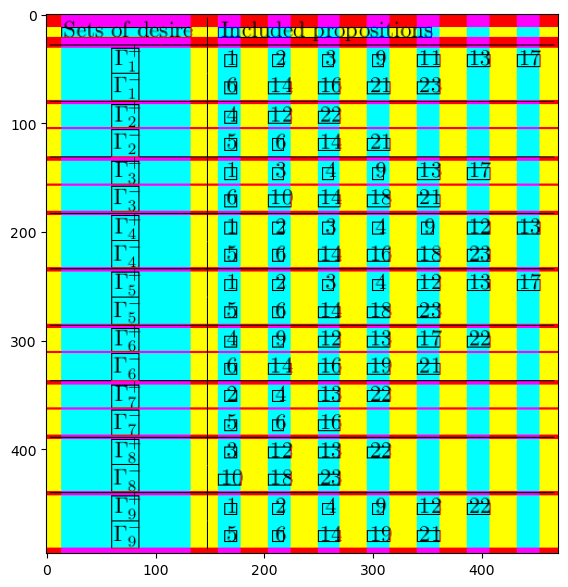

In [32]:
for c in cells_updt:
    lt, rb = (c['pos'][0], c['pos'][1]), (c['pos'][2], c['pos'][3])
    if c['flag'] == 1:
        cv.rectangle(img, lt, rb, (0,255,0), 1)
    elif c['flag'] == 2:
        cv.rectangle(img, lt, rb, (0,0,255), 1)
    else:
        cv.rectangle(img, lt, rb, (255,0,0), 1)
        
rMask, cMask = split_mask(img, cells)
MaskImg = np.stack([np.maximum(rMask, cMask)*255, 255-rMask*255, 255-cMask*255], axis=-1)
MaskImg = np.minimum(img, MaskImg)
view_imgs([MaskImg])

In [33]:
n_row_span_cells, n_col_span_cells = 0, 0

for c in cells_updt:
    if c['flag'] == 1: n_row_span_cells += 1
    elif c['flag'] == 2: n_col_span_cells += 1

n_row_span_cells, n_col_span_cells

(0, 1)

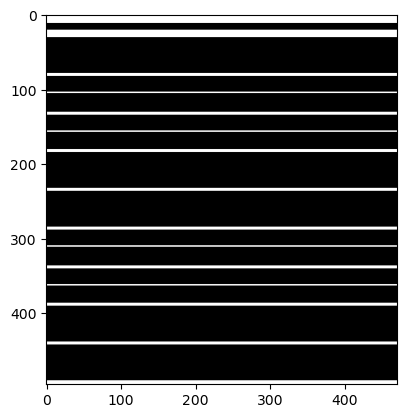

In [34]:
plt.imshow(rMask, cmap='gray')

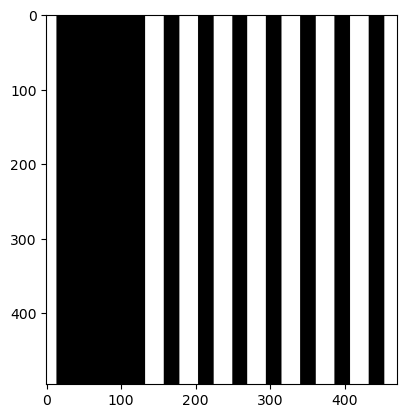

In [35]:
plt.imshow(cMask, cmap='gray')

In [36]:
cMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [37]:
def process_mask(rMask, cMask):
    res = {
        'rows': rMask[:, 0].tolist(),
        'columns': cMask[0, :].tolist()
    }
    return res

In [38]:
res = process_mask(rMask, cMask)
res['rows'][:20], res['columns'][:20]

([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [39]:
# create label folder for Split & Merge module if it hasn't been created
LABEL_TRAIN = os.path.join(SCITSR_TRAIN, 'label')

if not os.path.exists(LABEL_TRAIN):
    os.makedirs(LABEL_TRAIN)

In [40]:
def img_name_from_path(img_path):
    img_name = img_path.split(os.sep)[-1]
    names = img_name.split('.')[:-1]
    return '.'.join(names)

In [41]:
img_name = img_name_from_path(img_path)
img_name

'1211.6244v4.7'

In [42]:
def write_json(json_path, data):
    with open(json_path, 'w') as f:
        json.dump(data, f)

Putting everything together

In [43]:
def prepare_label_split(folder_path: str, json_path: str):
    '''
    Params:
        folder_path -- string, path to either train or test folder
        json_path -- string, path to json file to write ground truth into
    Returns:
        None
    '''
    imgs_folder = os.path.join(folder_path, 'img') # access image folder
    imgs_paths = get_files([imgs_folder], 'png') # get list of image paths inside image folder

    LABELS = {} 
    for i, img_path in enumerate(imgs_paths):
        img = load_img(img_path) # load image as numpy array 
        if img is None: continue
        # view_imgs([img])
        
        # Get table position inside pdf file
        img_pdf_path = img_path.replace('png', 'pdf').replace('img', 'pdf')
        left, top, right, bottom = get_table_pos(img_pdf_path)
        
        # Read .chunk file to get coordinates of cells inside table
        # and convert from pdf coordinates to png coordinates
        img_chunk_path = img_path.replace('png', 'chunk').replace('img', 'chunk')
        chunks = read_chunk(img_chunk_path, left, top)
        
        # Read .json file from structure folder to know whether a cell is a span-cell or single
        img_struct_path = img_path.replace('png', 'json').replace('img', 'structure')
        n_rows, n_cols, cells = read_cells(img_struct_path)

        # update cells so that they have coordinates from chunks
        cells = update_cells(cells, chunks)

        # get row and columns mask (2D) and turn them each into 1D list 
        rMask, cMask = split_mask(img, cells)
        label = process_mask(rMask, cMask)

        # get image name and add to list of labels
        img_name = img_name_from_path(img_path)
        LABELS[img_name] = label
        if (i + 1) % 100 == 0: 
            print(f"Got labels for {i+1} images!")

    with open(json_path, 'w') as f:
        json.dump(LABELS, f)
    return None

In [44]:
LABEL_TRAIN_SPLIT = os.path.join(SCITSR_TRAIN, 'label', 'split_label.json')
# print(LABEL_TRAIN_SPLIT)

prepare_label_split(SCITSR_TRAIN, LABEL_TRAIN_SPLIT)

Got labels for 100 images!
Got labels for 200 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/0705.1956v1.13.png
Got labels for 300 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/0804.1441v3.3.png
Got labels for 400 images!
Got labels for 500 images!
Got labels for 600 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1002.0561v1.6.png


libpng error: Read Error


Got labels for 700 images!
Got labels for 800 images!
Got labels for 900 images!
Got labels for 1000 images!
Got labels for 1100 images!
Got labels for 1200 images!
Got labels for 1300 images!
Got labels for 1400 images!
Got labels for 1500 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1210.6912v1.6.png
Got labels for 1600 images!
Got labels for 1700 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1303.6361v1.2.png


libpng error: Read Error


Got labels for 1800 images!
Got labels for 1900 images!
Got labels for 2000 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1311.4166v1.6.png
Got labels for 2200 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1402.1107v1.1.png
Got labels for 2300 images!
Got labels for 2400 images!
Got labels for 2500 images!
Got labels for 2600 images!
Got labels for 2700 images!
Got labels for 2800 images!
Got labels for 2900 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1412.1842v1.3.png
Got labels for 3000 images!
Got labels for 3100 images!
Got labels for 3200 images!
Got labels for 3300 images!
Got labels for 3400 images!
Got labels for 3500 images!
Got labels for 3600 images!
Got labels for 3700 images!
Got labels for 3800 images!
Got labels for 3900 images!
* Error: Unable to read image from /Users/longhoang/

libpng error: Read Error


* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1707.09406v1.2.png
Got labels for 8200 images!
Got labels for 8300 images!
Got labels for 8400 images!
Got labels for 8500 images!
Got labels for 8600 images!
Got labels for 8700 images!
Got labels for 8800 images!
Got labels for 8900 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1711.01711v11.3.png
Got labels for 9000 images!
Got labels for 9100 images!
Got labels for 9200 images!
Got labels for 9300 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1712.01039v2.4.png
Got labels for 9400 images!
Got labels for 9500 images!
Got labels for 9600 images!
Got labels for 9700 images!
Got labels for 9800 images!
Got labels for 9900 images!
Got labels for 10000 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1

libpng error: Read Error


* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1803.04786v1.4.png
Got labels for 10200 images!
Got labels for 10300 images!
Got labels for 10400 images!
Got labels for 10500 images!
Got labels for 10600 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1804.10337v1.1.png


libpng error: Read Error


Got labels for 10700 images!
Got labels for 10800 images!
Got labels for 10900 images!
Got labels for 11000 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1805.10499v1.1.png
Got labels for 11100 images!
Got labels for 11200 images!
Got labels for 11300 images!
Got labels for 11400 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1807.02983v1.2.png


libpng error: Read Error


Got labels for 11500 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1807.04686v1.1.png
Got labels for 11600 images!
Got labels for 11700 images!
* Error: Unable to read image from /Users/longhoang/Developer/table-recognition/data/SciTSR/train/img/1808.02152v1.1.png
Got labels for 11800 images!
Got labels for 11900 images!
Got labels for 12000 images!


In [45]:
with open(LABEL_TRAIN_SPLIT, 'r') as f:
    data = json.load(f)

len(data)

11971

In [46]:
test_label = data[img_name]
test_label['rows'] == res['rows'], test_label['columns'] == res['columns'], \
len(test_label['rows']) == img.shape[0], len(test_label['columns']) == img.shape[1]

(True, True, True, True)